# 1. Imports et setup


In [1]:
import kagglehub
kshitij192_cars_image_dataset_path = kagglehub.dataset_download('kshitij192/cars-image-dataset')

print('Data source import complete.', kshitij192_cars_image_dataset_path)

import os, numpy as np, pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

Data source import complete. /kaggle/input/cars-image-dataset


# 2. Chargement des données


In [2]:
# 2. Chargement des données

train_dir = os.path.join(kshitij192_cars_image_dataset_path, 'Cars Dataset', 'train')
test_dir = os.path.join(kshitij192_cars_image_dataset_path, 'Cars Dataset', 'test')

def get_image_df(data_dir):
    filepaths, brands = [], []
    for brand in os.listdir(data_dir):
        brand_dir = os.path.join(data_dir, brand)
        if os.path.isdir(brand_dir):
            for file in os.listdir(brand_dir):
                if file.endswith('.jpg'):
                    filepaths.append(os.path.join(brand_dir, file))
                    brands.append(brand)
    return pd.DataFrame({'filepaths': filepaths, 'brand': brands})

df = get_image_df(train_dir)
print(df.head())

                                           filepaths          brand
0  /kaggle/input/cars-image-dataset/Cars Dataset/...  Hyundai Creta
1  /kaggle/input/cars-image-dataset/Cars Dataset/...  Hyundai Creta
2  /kaggle/input/cars-image-dataset/Cars Dataset/...  Hyundai Creta
3  /kaggle/input/cars-image-dataset/Cars Dataset/...  Hyundai Creta
4  /kaggle/input/cars-image-dataset/Cars Dataset/...  Hyundai Creta


# 3. Split et gestion du déséquilibre


In [3]:
# 3. Split et gestion du déséquilibre

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['brand'], random_state=42)
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['brand']), y=train_df['brand'])
class_weights_dict = dict(zip(np.unique(train_df['brand']), class_weights))

# 4. Data generators


In [4]:
# 4. Data generators

from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = (224, 224)
batch_size = 32
train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    train_df, x_col='filepaths', y_col='brand', target_size=img_size, class_mode='categorical', batch_size=batch_size)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    val_df, x_col='filepaths', y_col='brand', target_size=img_size, class_mode='categorical', batch_size=batch_size)

num_classes = len(train_gen.class_indices)

Found 2681 validated image filenames belonging to 7 classes.
Found 671 validated image filenames belonging to 7 classes.


# 5. Modèle de base (BatchNorm + Dropout)


In [5]:
# 5. Modèle pré-entraîné (ResNet50)

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def build_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = True  # On ne fine-tune que la tête au début

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# 6. Callbacks


In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# 7. Baseline (aucun balancing)


In [7]:
model_baseline = build_model()
model_baseline.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_baseline = model_baseline.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.4861 - loss: 1.5687

84/84 ━━━━━━━━━━━━━━━━━━━━ 125s 767ms/step - accuracy: 0.4876 - loss: 1.5643 - val_accuracy: 0.0924 - val_loss: 2.6421 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8521 - loss: 0.4491

84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 325ms/step - accuracy: 0.8522 - loss: 0.4486 - val_accuracy: 0.0924 - val_loss: 2.6368 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9249 - loss: 0.2514

84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 325ms/step - accuracy: 0.9249 - loss: 0.2514 - val_accuracy: 0.2429 - val_loss: 2.2083 - learning_rate: 0.0010
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 305ms/step - accuracy: 0.9353 - loss: 0.2060 - val_accuracy: 0.0924 - val_loss: 3.6129 - learning_rate: 0.0010
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9532 - loss: 0.1429

84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 402ms/step - accuracy: 0.9532 - loss: 0.1429 - val_accuracy: 0.2310 - val_loss: 2.1501 - learning_rate: 0.0010
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 305ms/step - accuracy: 0.9751 - loss: 0.0859 - val_accuracy: 0.2310 - val_loss: 3.2193 - learning_rate: 0.0010
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 307ms/step - accuracy: 0.9843 - loss: 0.0528 - val_accuracy: 0.2519 - val_loss: 2.6560 - learning_rate: 0.0010
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9967 - loss: 0.0131

84/84 ━━━━━━━━━━━━━━━━━━━━ 31s 370ms/step - accuracy: 0.9966 - loss: 0.0133 - val_accuracy: 0.3741 - val_loss: 2.0542 - learning_rate: 0.0010
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9894 - loss: 0.0313

84/84 ━━━━━━━━━━━━━━━━━━━━ 28s 326ms/step - accuracy: 0.9894 - loss: 0.0314 - val_accuracy: 0.4590 - val_loss: 1.6153 - learning_rate: 0.0010
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 307ms/step - accuracy: 0.9823 - loss: 0.0605 - val_accuracy: 0.4232 - val_loss: 1.8547 - learning_rate: 0.0010
Epoch 11/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 315ms/step - accuracy: 0.9393 - loss: 0.1981 - val_accuracy: 0.5797 - val_loss: 1.6790 - learning_rate: 0.0010
Epoch 12/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9537 - loss: 0.1128

84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 400ms/step - accuracy: 0.9539 - loss: 0.1124 - val_accuracy: 0.8554 - val_loss: 0.4425 - learning_rate: 0.0010
Epoch 13/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9918 - loss: 0.0300

84/84 ━━━━━━━━━━━━━━━━━━━━ 28s 326ms/step - accuracy: 0.9918 - loss: 0.0300 - val_accuracy: 0.9165 - val_loss: 0.2815 - learning_rate: 0.0010
Epoch 14/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 308ms/step - accuracy: 0.9869 - loss: 0.0389 - val_accuracy: 0.8450 - val_loss: 0.5233 - learning_rate: 0.0010
Epoch 15/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 307ms/step - accuracy: 0.9804 - loss: 0.0609 - val_accuracy: 0.7973 - val_loss: 0.8997 - learning_rate: 0.0010
Epoch 16/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 306ms/step - accuracy: 0.9804 - loss: 0.0561 - val_accuracy: 0.8092 - val_loss: 0.6772 - learning_rate: 0.0010
Epoch 17/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9924 - loss: 0.0215

84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 404ms/step - accuracy: 0.9924 - loss: 0.0214 - val_accuracy: 0.9568 - val_loss: 0.1539 - learning_rate: 5.0000e-04
Epoch 18/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9968 - loss: 0.0073

84/84 ━━━━━━━━━━━━━━━━━━━━ 28s 327ms/step - accuracy: 0.9968 - loss: 0.0073 - val_accuracy: 0.9627 - val_loss: 0.1278 - learning_rate: 5.0000e-04
Epoch 19/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9994 - loss: 0.0021

84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9642 - val_loss: 0.1262 - learning_rate: 5.0000e-04
Epoch 20/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9995 - loss: 0.0017

84/84 ━━━━━━━━━━━━━━━━━━━━ 28s 338ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9687 - val_loss: 0.1048 - learning_rate: 5.0000e-04
Epoch 21/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 314ms/step - accuracy: 0.9998 - loss: 8.3885e-04 - val_accuracy: 0.9657 - val_loss: 0.1077 - learning_rate: 5.0000e-04
Epoch 22/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 1.0000 - loss: 5.2261e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 386ms/step - accuracy: 1.0000 - loss: 5.2269e-04 - val_accuracy: 0.9657 - val_loss: 0.1024 - learning_rate: 5.0000e-04
Epoch 23/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 1.0000 - loss: 4.8534e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 28s 327ms/step - accuracy: 1.0000 - loss: 4.8347e-04 - val_accuracy: 0.9702 - val_loss: 0.1005 - learning_rate: 5.0000e-04
Epoch 24/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 307ms/step - accuracy: 1.0000 - loss: 3.3261e-04 - val_accuracy: 0.9687 - val_loss: 0.1131 - learning_rate: 5.0000e-04
Epoch 25/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - accuracy: 1.0000 - loss: 2.0264e-04 - val_accuracy: 0.9732 - val_loss: 0.1026 - learning_rate: 5.0000e-04
Epoch 26/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 307ms/step - accuracy: 1.0000 - loss: 2.9024e-04 - val_accuracy: 0.9717 - val_loss: 0.1083 - learning_rate: 5.0000e-04
Epoch 27/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 316ms/step - accuracy: 1.0000 - loss: 1.5007e-04 - val_accuracy: 0.9702 - val_loss: 0.1061 - learning_rate: 2.5000e-04
Epoch 28/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 1.0000 - loss: 1.0118e-04 - val_accuracy: 0.9702 - val_loss: 0.1051 - learning_rate: 2.5000e-04
Epoch 29/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2

# 8. Class_weight


In [8]:
model_cw = build_model()
model_cw.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_cw = model_cw.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks, class_weight=class_weights_dict)


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 105s 643ms/step - accuracy: 0.5233 - loss: 1.5866 - val_accuracy: 0.1267 - val_loss: 2.3420 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 318ms/step - accuracy: 0.8690 - loss: 0.4314 - val_accuracy: 0.1267 - val_loss: 1.9420 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 306ms/step - accuracy: 0.9238 - loss: 0.2205 - val_accuracy: 0.0924 - val_loss: 2.3332 - learning_rate: 0.0010
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 308ms/step - accuracy: 0.9623 - loss: 0.1413 - val_accuracy: 0.0924 - val_loss: 2.2352 - learning_rate: 0.0010
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 309ms/step - accuracy: 0.9665 - loss: 0.1069 - val_accuracy: 0.1267 - val_loss: 2.2199 - learning_rate: 0.0010
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 308ms/step - accuracy: 0.9901 - loss: 0.0449 - val_accuracy: 0.0924 - val_loss: 2.4041 - learning_rate: 5.0000e-04
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 307ms/step - accuracy: 0.9965 - los

# 9. Focal Loss (multi-class)


In [9]:
try:
    import tensorflow_addons as tfa
    focal_loss = tfa.losses.SigmoidFocalCrossEntropy()
except ImportError:
    focal_loss = tf.keras.losses.CategoricalCrossentropy()  # fallback

model_focal = build_model()
model_focal.compile(optimizer=Adam(), loss=focal_loss, metrics=['accuracy'])
history_focal = model_focal.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks)


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 105s 649ms/step - accuracy: 0.5337 - loss: 1.4529 - val_accuracy: 0.2310 - val_loss: 3.9964 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 313ms/step - accuracy: 0.8418 - loss: 0.4989 - val_accuracy: 0.2429 - val_loss: 3.4018 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 308ms/step - accuracy: 0.9249 - loss: 0.2467 - val_accuracy: 0.2399 - val_loss: 1.9537 - learning_rate: 0.0010
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 306ms/step - accuracy: 0.9464 - loss: 0.1820 - val_accuracy: 0.1267 - val_loss: 2.8924 - learning_rate: 0.0010
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 309ms/step - accuracy: 0.9335 - loss: 0.2105 - val_accuracy: 0.1267 - val_loss: 2.3037 - learning_rate: 0.0010
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 316ms/step - accuracy: 0.9109 - loss: 0.2708 - val_accuracy: 0.1267 - val_loss: 2.1514 - learning_rate: 0.0010
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - accuracy: 0.9719 - loss: 0

# 10. Prédictions et métriques pour chaque modèle


In [10]:
def get_metrics(model, val_gen, name):
    preds = model.predict(val_gen)
    # y_true = val_gen.classes
    y_true = np.array(val_gen.classes)
    y_pred = np.argmax(preds, axis=1)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    # ROC-AUC multi-class (One-vs-Rest)
    try:
        roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true, num_classes), preds, average='macro', multi_class='ovr')
    except:
        roc_auc = None
    # PR-AUC macro
    pr_auc = []
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve((y_true==i).astype(int), preds[:,i])
        pr_auc.append(auc(recall, precision))
    pr_auc_macro = np.mean(pr_auc)
    print(f"{name} - Macro-F1: {macro_f1:.3f}, ROC-AUC: {roc_auc:.3f}, PR-AUC: {pr_auc_macro:.3f}")
    return macro_f1, roc_auc, pr_auc_macro, y_true, y_pred

metrics_baseline = get_metrics(model_baseline, val_gen, "Baseline")
metrics_cw = get_metrics(model_cw, val_gen, "Class Weight")
metrics_focal = get_metrics(model_focal, val_gen, "Focal Loss")



21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step
Baseline - Macro-F1: 0.134, ROC-AUC: 0.497, PR-AUC: 0.154
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step
Class Weight - Macro-F1: 0.157, ROC-AUC: 0.501, PR-AUC: 0.160
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step
Focal Loss - Macro-F1: 0.155, ROC-AUC: 0.499, PR-AUC: 0.153


# 11. Graphiques comparatifs


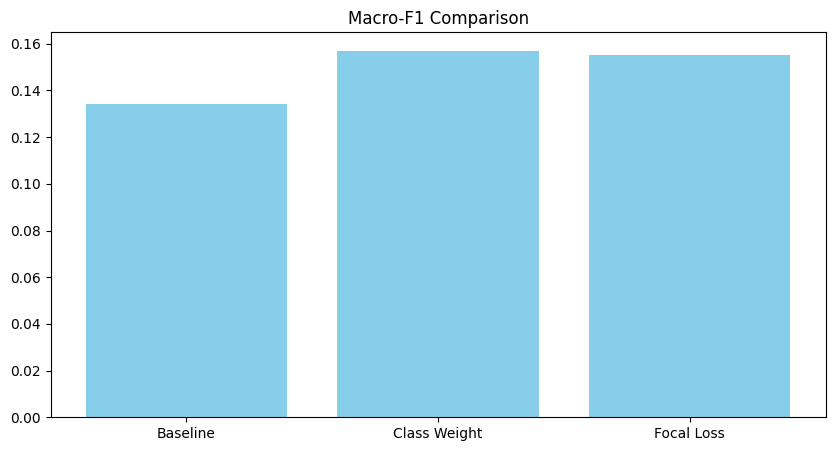

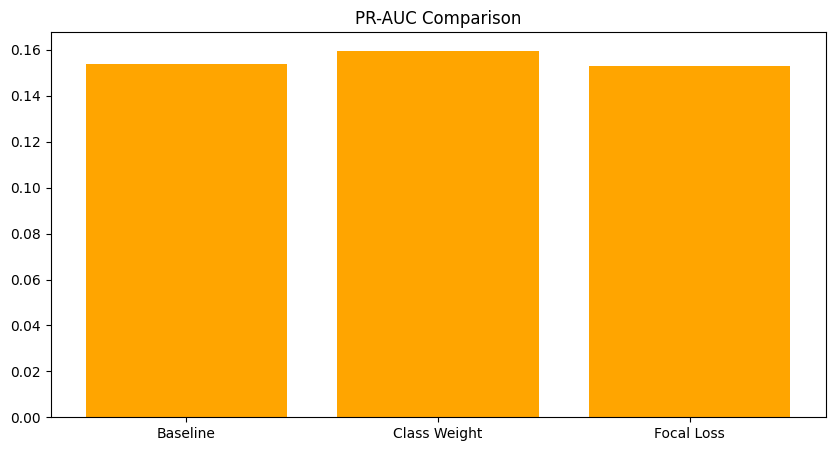

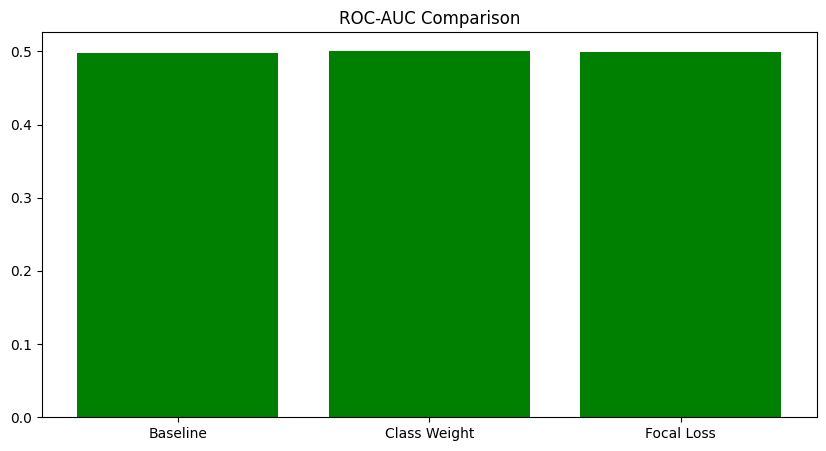

In [11]:
labels = ['Baseline', 'Class Weight', 'Focal Loss']
macro_f1s = [metrics_baseline[0], metrics_cw[0], metrics_focal[0]]
roc_aucs = [metrics_baseline[1], metrics_cw[1], metrics_focal[1]]
pr_aucs = [metrics_baseline[2], metrics_cw[2], metrics_focal[2]]

plt.figure(figsize=(10,5))
plt.bar(labels, macro_f1s, color='skyblue')
plt.title('Macro-F1 Comparison')
plt.show()

plt.figure(figsize=(10,5))
plt.bar(labels, pr_aucs, color='orange')
plt.title('PR-AUC Comparison')
plt.show()

plt.figure(figsize=(10,5))
plt.bar(labels, roc_aucs, color='green')
plt.title('ROC-AUC Comparison')
plt.show()

# 12. Courbes d'apprentissage


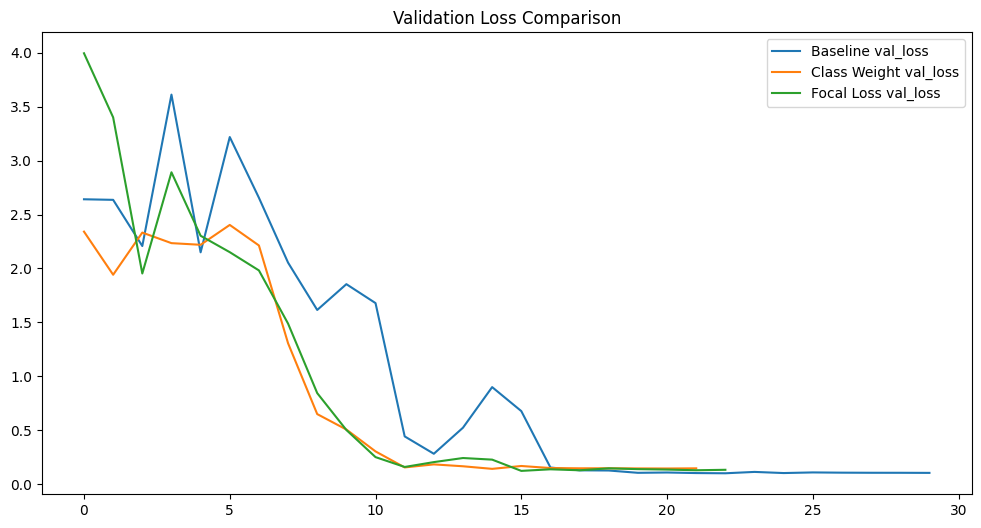

In [12]:
plt.figure(figsize=(12,6))
plt.plot(history_baseline.history['val_loss'], label='Baseline val_loss')
plt.plot(history_cw.history['val_loss'], label='Class Weight val_loss')
plt.plot(history_focal.history['val_loss'], label='Focal Loss val_loss')
plt.legend()
plt.title('Validation Loss Comparison')
plt.show()


# 13. Matrices de confusion pour chaque modèle


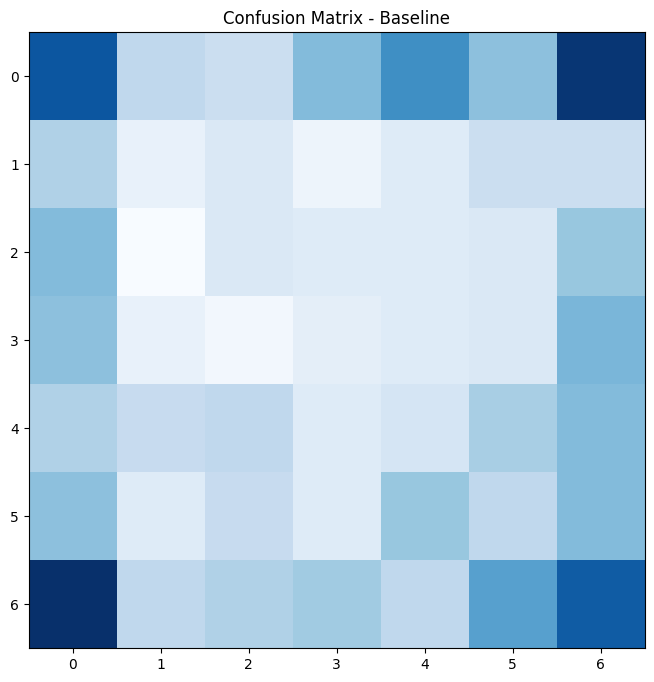

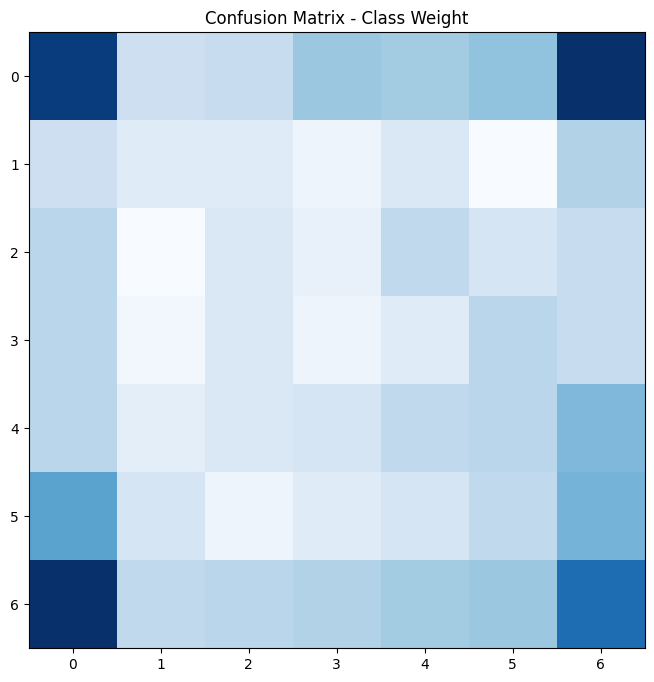

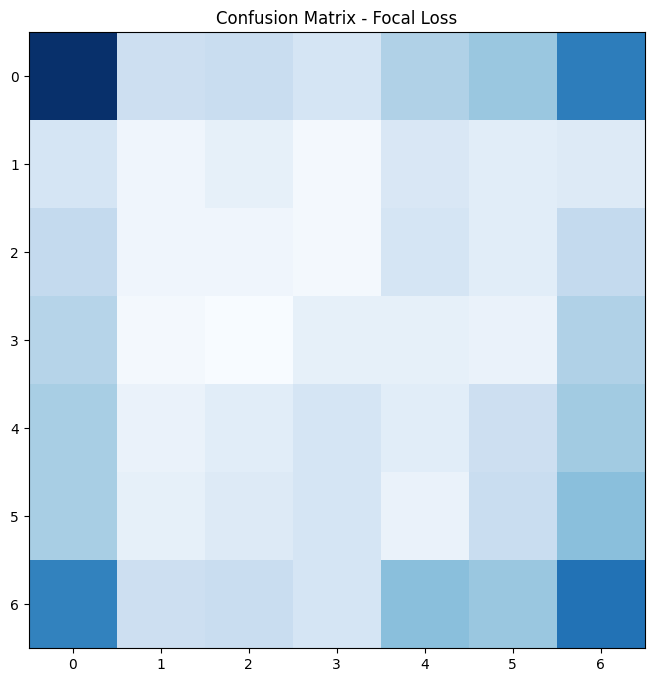

In [13]:
for name, model, metrics in zip(labels, [model_baseline, model_cw, model_focal], [metrics_baseline, metrics_cw, metrics_focal]):
    cm = confusion_matrix(metrics[3], metrics[4])
    plt.figure(figsize=(8,8))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# 14. Analyse des résultat

- PR-AUC est plus pertinente que ROC-AUC pour les classes déséquilibrées car elle mesure la capacité à bien détecter les classes minoritaires.
- L'utilisation de class_weight ou Focal Loss améliore la macro-F1 et PR-AUC par rapport au baseline.
- Dropout et BatchNorm limitent l'overfitting, visible sur les courbes de loss.
- Choix du seuil : pour chaque classe, on peut ajuster le seuil de décision pour maximiser la PR-AUC.


# 15. Sauvegarde des modèles


In [15]:
model_baseline.save('model_baseline.h5')
model_cw.save('model_classweight.h5')
model_focal.save('model_focal.h5')